# Calculus

Let ${\mathbf{x}}$ be an $n$-dimensional vector, the following rules are often used when differentiating functions:

- For all $\mathbf{A} \in \mathbb{R}^{m \times n}$, $\triangledown_{x}\mathbf{Ax} = \mathbf{A}^{\top}$
- For all $\mathbf{A} \in \mathbb{R}^{n \times m}$, $\triangledown_{x}\mathbf{x^{\top}A} = \mathbf{A}$
- For all $\mathbf{A} \in \mathbb{R}^{n \times n}$, $\triangledown_{x}\mathbf{x^{\top}Ax} = (\mathbf{A} + \mathbf{A}^{\top})\mathbf{x}$
- $\triangledown_{x}||\mathbf{x}||^2 = \triangledown_{x}\mathbf{x}^{\top}\mathbf{x} = 2\mathbf{x}$

# Automatic Differentiation

## Backward for Non-Scalar Variables

从技术上而言，当 $y$ 不是一个标量而是一个向量(m-dimensional) 对向量 $x$(n-dimensional)求导，求导结果是一个称之为 Jacobian($m \times n$ matrix)的矩阵。

> 在向量求导中，这属于向量对向量求导。

在深度学习（机器学习）中，通常对向量求导的作用是最小化损失函数，其核心是计算在一个批次中每个样本的偏导数之和，因此在 MXNet 框架中，对于向量对向量求导会按照向量求和的方式求导，也就是将向量对向量求导变为标量对向量求导。

下面的例子就说明了 MXNet 的这种处理方法。

In [1]:
from mxnet import autograd, np, npx

In [2]:
npx.set_np()

In [3]:
# vector x
x = np.arange(4)
x

array([0., 1., 2., 3.])

In [4]:
# 向量对向量求导
x.attach_grad()
with autograd.record():
    y = x * x
y.backward()
y, x.grad

(array([0., 1., 4., 9.]), array([0., 2., 4., 6.]))

In [5]:
# 标量对向量求导
u = x.copy()
u.attach_grad()
with autograd.record():
    v = (u * u).sum()  # v is a scalar
v.backward()
v, u.grad, x.grad, x.grad == u.grad

(array(14.),
 array([0., 2., 4., 6.]),
 array([0., 2., 4., 6.]),
 array([1., 1., 1., 1.]))

## Detaching Computation

分离计算，有时候我们希望将一些计算从计算图中移除。这句话不好理解，用例子解释一下，假设我们有 $y=f(x)=x^2$ 和 $z=f(x,y)=xy=x^3$，求 $\frac{\partial{z}}{\partial{x}}$，具体求导算法如下


In [6]:
x = np.arange(4)
x.attach_grad()
with autograd.record():
    y = x * x
    z = y * x
z.backward()
x.grad, u

(array([ 0.,  3., 12., 27.]), array([0., 1., 2., 3.]))

这里详细解释一下背后的数学计算过程：

向量 $\vec{x}=\begin{bmatrix} 0 \\ 1 \\ 2 \\ 3 \end{bmatrix}$, 可以使用 $\vec{x}=\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$ 表示。 $z=yx=x^3=\begin{bmatrix} x_1^3 \\ x_2^3 \\ x_3^3 \\ x_4^3 \end{bmatrix}$，根据[上一章节](#Backward-for-Non-Scalar-Variables)的说明，对于结果是向量（这里就是$z$的计算结果是一个向量），MXNET 框架会将其转换为向量求和后来求导，也就是 $z=x_1^3+x_2^3+x_3^3+x_4^3$，此时就是$z$结果是一个标量，使用标量对向量求导的规则，可以得到：

$
\frac{\partial{z}}{\partial{x}}=
\begin{bmatrix}
    \frac{\partial{(x_1^3+x_2^3+x_3^3+x_4^3)}}{\partial{x_1}} \\
    \frac{\partial{(x_1^3+x_2^3+x_3^3+x_4^3)}}{\partial{x_2}} \\
    \frac{\partial{(x_1^3+x_2^3+x_3^3+x_4^3)}}{\partial{x_3}} \\
    \frac{\partial{(x_1^3+x_2^3+x_3^3+x_4^3)}}{\partial{x_4}} \\
\end{bmatrix}
=
\begin{bmatrix}
    3x_1^2 \\ 3x_2^2 \\ 3x_3^2 \\ 3x_4^2
\end{bmatrix}
= 3\vec{x}\vec{x}
= 3
\begin{bmatrix} 0 \\ 1 \\ 2 \\ 3 \end{bmatrix}
\begin{bmatrix} 0 \\ 1 \\ 2 \\ 3 \end{bmatrix}
=
\begin{bmatrix} 0 \\ 3 \\ 12 \\ 27 \end{bmatrix}
$


基于某种原因，在求导过程中我们想让 $y$ 被认为是一个常量，此时可以使用下面的方法

In [12]:
with autograd.record():
    y = x * x
    u = y.detach()
    z = u * x
z.backward()
x.grad, u

(array([0., 1., 4., 9.]), array([0., 1., 4., 9.]))

这里的数学计算过程与上面的略有不同：

向量 $\vec{x}=\begin{bmatrix} 0 \\ 1 \\ 2 \\ 3 \end{bmatrix}$, 可以使用 $\vec{x}=\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$ 表示。 <span class="girk">这里的 $y$ 由于进行了“分离”操作因此它不再被当做一个变量看待，而是当做一个常量</span>，即 $y=xx=\begin{bmatrix} 0 \\ 1 \\ 2 \\ 3 \end{bmatrix}\begin{bmatrix} 0 \\ 1 \\ 2 \\ 3 \end{bmatrix}=\begin{bmatrix} 0 \\ 1 \\ 4 \\ 9 \end{bmatrix}$ 。此时，$z=yx=\begin{bmatrix} 0 \\ 1 \\ 4 \\ 9 \end{bmatrix}\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$，根据[上一章节](#Backward-for-Non-Scalar-Variables)的说明，对于结果是向量（这里就是$z$的计算结果是一个向量），MXNET 框架会将其转换为向量求和后来求导，也就是 $z=0x_1+x_2+4x_3+9x_4$，此时就是$z$结果是一个标量，使用标量对向量求导的规则，可以得到：

$
\frac{\partial{z}}{\partial{x}}=
\begin{bmatrix}
    \frac{\partial{(0x_1+x_2+4x_3+9x_4)}}{\partial{x_1}} \\
    \frac{\partial{(0x_1+x_2+4x_3+9x_4)}}{\partial{x_2}} \\
    \frac{\partial{(0x_1+x_2+4x_3+9x_4)}}{\partial{x_3}} \\
    \frac{\partial{(0x_1+x_2+4x_3+9x_4)}}{\partial{x_4}} \\
\end{bmatrix}
=
\begin{bmatrix}
    0 \\ 1 \\ 4 \\ 9
\end{bmatrix}
$


## Exercises

1. Let $f(x)=\sin(x)$. Plot $f(x)$ and $\frac{\mathrm{d}f(x)}{\mathrm{d}x}$

In [20]:
import d2l
from mxnet import np, npx, autograd

In [16]:
npx.set_np()

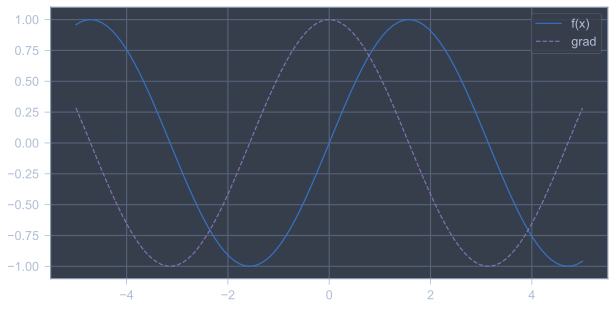

In [45]:
def f(x):
    return np.sin(x)


x = np.linspace(-5, 5, 100)
x.attach_grad()
with autograd.record():
    y = f(x)
y.backward()
d2l.plot(x, [f(x), x.grad], figsize=(10, 5), legend=['f(x)', 'grad'])

# Probability


In [1]:
import d2l
from mxnet import np, npx

In [2]:
npx.set_np()

In [8]:
fair_probs = [1.0/6] * 6
counts = np.random.multinomial(10, fair_probs, size=3)
cum_counts = counts.astype(np.float32).cumsum(axis=0)
estimates = cum_counts / cum_counts.sum(axis=1, keepdims=True)
counts, cum_counts, estimates

(array([[ 0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0, 10],
        [ 1,  3,  0,  0,  0,  6]], dtype=int64),
 array([[ 0.,  0.,  0.,  0.,  0., 10.],
        [ 0.,  0.,  0.,  0.,  0., 20.],
        [ 1.,  3.,  0.,  0.,  0., 26.]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        ],
        [0.03333334, 0.1       , 0.        , 0.        , 0.        ,
         0.8666667 ]]))